In [9]:
import os
import numpy as np
import re

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

from pathlib import Path


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

data_dir = "./data"

print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [10]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [11]:
data_dict = load_measurements("data/", "w_*.txt")

# 2. Create two basis key groups (regex matched)
amp_keys = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
pha_keys = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]

amp_dict = {k: data_dict[k] for k in amp_keys}
pha_dict = {k: data_dict[k] for k in pha_keys}

amp_loader           = MultiBasisDataLoader(amp_dict, batch_size=128)
pha_loader           = MultiBasisDataLoader(pha_dict, batch_size=128)

In [57]:
from typing import Tuple, Dict, Any
from typing import Optional
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.core import freeze, unfreeze
from jax.nn.initializers import normal, zeros
from collections.abc import Callable, Sequence


class DoubleRBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    def setup(self):
        self.W_amp = self.param("W_amp", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_amp = self.param("b_amp", nn.initializers.zeros, (self.n_visible,))
        self.c_amp = self.param("c_amp", nn.initializers.zeros, (self.n_hidden,))

        self.W_pha = self.param("W_pha", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param("b_pha", nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param("c_pha", nn.initializers.zeros, (self.n_hidden,))

        self.rotators = {
            'X': jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / jnp.sqrt(2),
            'Y': jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / jnp.sqrt(2),
        }

    def __call__(
            self,
            data_dict: Dict[str, jnp.ndarray],
            aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:

        random_key = aux_vars.get("random_key")
        persistent_chains = aux_vars.get("v_persistent", None)

        aux_vars = dict()

        # amplitude training
        comp_basis = 'Z' * self.n_visible
        if len(data_dict) == 1 and comp_basis in data_dict:
            data_batch = data_dict[comp_basis]
            pcd_loss, persistent_chains, random_key = self._loss_amp(data_batch, persistent_chains, random_key)

            if persistent_chains is not None:
                aux_vars["v_persistent"] = persistent_chains

            aux_vars["random_key"] = random_key

            return pcd_loss, aux_vars


        # phase training
        all_two_different = all(sum(b != 'Z' for b in basis) == 2 for basis in data_dict)
        if all_two_different:
            phase_loss = self._loss_phase(data_dict)
            return phase_loss, aux_vars

        raise ValueError("Encountered batch of unsupported basis.")


    def _loss_amp(self, data_batch, persistent_chains, random_key):
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        if persistent_chains is None:
            random_key, random_key_bern = jax.random.split(random_key)
            chains = jax.random.bernoulli(random_key_bern, p=0.5, shape=(self.n_chains, self.n_visible))
            model_batch, random_key = self._gibbs_sample(W, b, c, chains, random_key, k=self.k)
        else:
            model_batch, random_key = self._gibbs_sample(W, b, c, persistent_chains, random_key, k=self.k)
            persistent_chains = model_batch

        model_batch = jax.lax.stop_gradient(model_batch)  # stopping gradient tracking before computing the loss

        # stacking the batches here could maybe yield some performance, not sure though since half the data is gradient detached
        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)
        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)

        return pcd_loss, persistent_chains, random_key


    def _loss_phase(self, data_dict: Dict[str, jnp.ndarray]) -> jnp.ndarray:
        total_loss = 0.0

        for basis, batch in data_dict.items():  # batch: shape (B, n)
            amps = self.get_rotated_amplitude(batch, basis)  # shape (B,)
            log_probs = jnp.log(jnp.abs(amps) ** 2 + 1e-10)   # shape (B,)
            total_loss -= jnp.mean(log_probs)  # NLL

        return total_loss

    @staticmethod
    def _free_energy(W, b, c, v):
        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    # amplitude RBM specific

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v, key = state

        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_init, rng, k=1, T=1.0):
        body_fun = lambda i, state: DoubleRBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    # phase RBM specific

    def get_amplitude(self, sigma_batch: jnp.ndarray) -> jnp.complex64:
        W_amp = self.variables["params"]["W_amp"]
        b_amp = self.variables["params"]["b_amp"]
        c_amp = self.variables["params"]["c_amp"]

        W_pha = self.variables["params"]["W_pha"]
        b_pha = self.variables["params"]["b_pha"]
        c_pha = self.variables["params"]["c_pha"]

        F_amp = self._free_energy(W_amp, b_amp, c_amp, sigma_batch)
        F_pha = self._free_energy(W_pha, b_pha, c_pha, sigma_batch)

        return jnp.exp(-0.5 * F_amp) * jnp.exp(-0.5j * F_pha)


    def get_rotated_amplitude(self, sigma_b: jnp.ndarray, basis: Sequence[str]) -> jnp.ndarray:
        B, n = sigma_b.shape

        non_z = [i for i, b in enumerate(basis) if b != 'Z']
        if len(non_z) != 2:
            raise ValueError("Only bases with exactly two non-Z entries are supported.")

        j, k = non_z
        Rj = self.rotators[basis[j]]
        Rk = self.rotators[basis[k]]
        U = jnp.kron(Rj, Rk)  # shape (4, 4)

        # 4 local bit combinations to insert at positions j and k
        local_bit_combos = jnp.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]], dtype=sigma_b.dtype)

        # Expand: (B, n) → (4, B, n) with 4 modified versions per sample
        sigma_b_tiled = jnp.repeat(sigma_b[None, :, :], 4, axis=0)  # (4, B, n)
        sigma_b_modified = sigma_b_tiled.at[:, :, [j, k]].set(local_bit_combos[:, None, :])  # (4, B, n)

        # Reshape to (4B, n)
        sigma_b_flat = sigma_b_modified.transpose(1, 0, 2).reshape(4 * B, n)

        # Single call to get_amplitudes
        psis_flat = self.get_amplitudes(sigma_b_flat)  # shape (4B,)
        psis = psis_flat.reshape(B, 4)  # shape (B, 4)

        # Compute index into rotated basis
        idx_in = (sigma_b[:, j].astype(int) << 1) | sigma_b[:, k].astype(int)  # shape (B,)

        # Apply U[:, idx_in] ⋅ psis per batch entry
        U_selected = U[:, idx_in]  # shape (4, B)
        amp = jnp.einsum("bi,ib->b", psis, U_selected)  # shape (B,)

        return amp

    @staticmethod
    def _annealing_step(i, state, W, b, c, T_schedule):
        v, rng = state
        T = T_schedule[i]
        v_next, rng_next = DoubleRBM._gibbs_sample(W, b, c, v, rng, k=1, T=T)
        return v_next, rng_next

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:
        # use amplitude parameters
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        state = (v, rng)

        body_fun = lambda i, s: DoubleRBM._annealing_step(i, s, W, b, c, T_schedule)
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, state)
        return v_final

In [58]:
class RBMTrainState(train_state.TrainState):
    """Immutable training container for optimizer, params, step, etc."""
    pass

@jax.jit
def train_step(state: RBMTrainState,
               batch: dict[str, jnp.ndarray],
               v_persistent: jnp.ndarray,
               key: PRNGKey):

    def loss_fn(params):
        return state.apply_fn({'params': params}, batch, {
            "v_persistent": v_persistent,
            "random_key": key
        })

    (loss, aux), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux["v_persistent"], aux["random_key"]



In [59]:
def train_rbm(state: RBMTrainState,
              loader: MultiBasisDataLoader,
              num_epochs: int,
              rng: PRNGKey,
              pcd_reset: int = 50):

    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, data_dict in enumerate(loader):
            #print("Batch keys:", list(data_dict.keys()))  # <- DEBUG

            batch = next(iter(data_dict.values()))  # get one array from dict
            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=batch.shape).astype(jnp.float32)

            state, loss, v_persistent, rng = train_step(state, data_dict, v_persistent, rng)

            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / batch_count
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng


In [214]:
# ---- hyperparameters ----
batch_size    = 6400
visible_units = 15
hidden_units  = 30 # larger gives one-hot
k_steps       = 20
lr            = 1e-2
num_epochs    = 300
pcd_reset     = 64000 # longer works better? (more homogenous distribution over various one-hots)

rng = PRNGKey(42)

# ---- prepare loader ----
train_loader = amp_loader

# ---- init model ----
model = DoubleRBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)
rng, init_key = jax.random.split(rng)

dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
z_basis = 'Z' * visible_units  # assuming the basis is Z for the dummy batch
dummy_batch_dict = {z_basis: dummy_batch}

params = model.init(
    init_key,
    dummy_batch_dict,
    {
        "v_persistent": dummy_batch,
        "random_key": rng
    }
)["params"]

# ---- create training state ----
optimizer = optax.adam(learning_rate=lr)
state = RBMTrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# ---- train ----
state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng, pcd_reset)

Epoch [1/300] - Free Energy Loss: -0.4362
Epoch [2/300] - Free Energy Loss: -0.0880
Epoch [3/300] - Free Energy Loss: -0.0517
Epoch [4/300] - Free Energy Loss: -0.0583
Epoch [5/300] - Free Energy Loss: -0.0697
Epoch [6/300] - Free Energy Loss: -0.0683
Epoch [7/300] - Free Energy Loss: -0.0354
Epoch [8/300] - Free Energy Loss: -0.0345
Epoch [9/300] - Free Energy Loss: 0.0034
Epoch [10/300] - Free Energy Loss: -0.0285
Epoch [11/300] - Free Energy Loss: -0.0079
Epoch [12/300] - Free Energy Loss: 0.0036
Epoch [13/300] - Free Energy Loss: -0.0183
Epoch [14/300] - Free Energy Loss: 0.0044
Epoch [15/300] - Free Energy Loss: -0.0018
Epoch [16/300] - Free Energy Loss: 0.0251
Epoch [17/300] - Free Energy Loss: -0.0282
Epoch [18/300] - Free Energy Loss: 0.0345
Epoch [19/300] - Free Energy Loss: 0.0184
Epoch [20/300] - Free Energy Loss: 0.0106
Epoch [21/300] - Free Energy Loss: 0.0538
Epoch [22/300] - Free Energy Loss: -0.0174
Epoch [23/300] - Free Energy Loss: 0.0154
Epoch [24/300] - Free Energy 

Text(0, 0.5, 'Free Energy Loss')

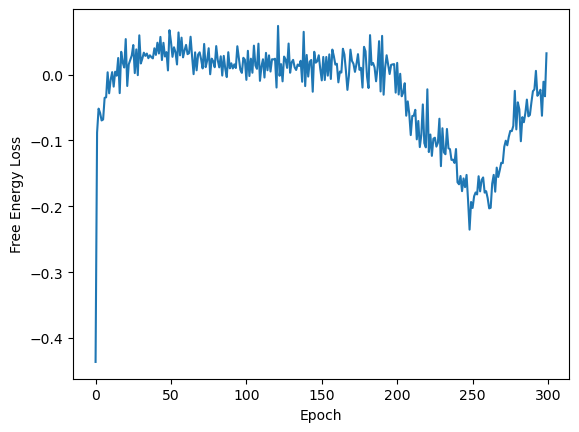

In [215]:
plt.plot([metrics[epoch]['free_energy_loss'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [216]:
samples = model.apply(
    {"params": state.params},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    rng=rng,
    method=DoubleRBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.0471, 0.1183, 0.0444, 0.0945, 0.0536, 0.0521, 0.0714, 0.0411,
       0.0721, 0.0587, 0.1183, 0.0492, 0.0629, 0.0636, 0.0617],      dtype=float32)

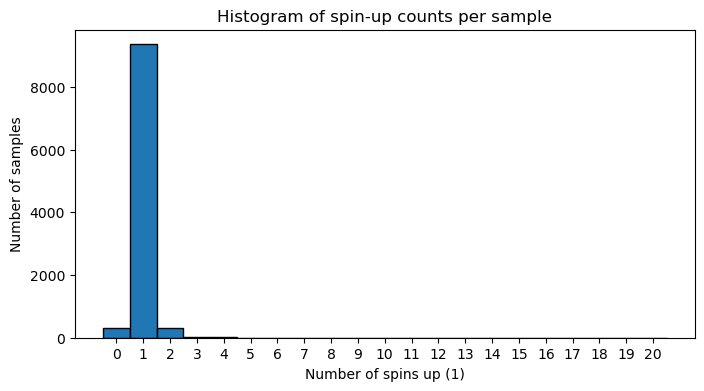

In [217]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [218]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in amp_loader:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.06171875, 0.06703125, 0.0665625 , 0.0659375 , 0.061875  ,
       0.06703125, 0.0646875 , 0.06875   , 0.06921875, 0.060625  ,
       0.07125   , 0.0665625 , 0.07484375, 0.0671875 , 0.06671875],      dtype=float32)

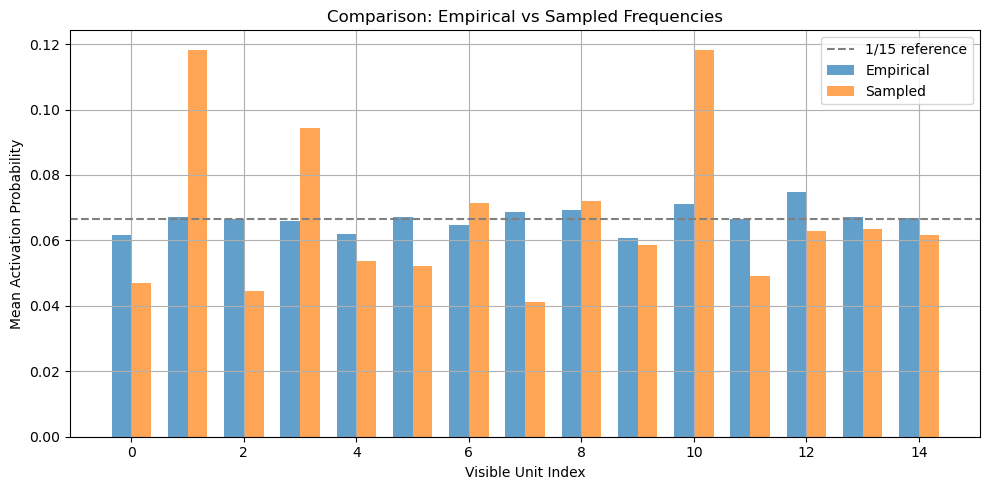

In [219]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()